In [1]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [2]:
df_jo.columns

Index(['id_cr', 'id_fe', 'fe_cr_id', 'user_id', 'active', 'created_at',
       'created_at_fe', 'amount', 'fee', 'stat_cr', 'stat_fe', 'transfer_type',
       'type', 'to_receive_ini', 'to_receive_bank', 'to_reimbur',
       'to_reimbur_cash', 'to_end', 'to_send', 'send_at', 'cr_received_date',
       'money_back_date', 'reimbursement_date', 'paid_at', 'charge_moment',
       'moderated_at', 'reason', 'category', 'from_date', 'to_date',
       'recovery_status', 'updated_at', 'reco_creation', 'reco_last_update',
       'updated_at_fe', 'Mes_created_at', 'cash_request_received_date',
       'created_at_slot', 'created_at_dow', 'needs_m_check_recov', 'n_fees',
       'n_backs', 'n_recovery', 'n_incidents', 'created_at_w', 'n_cr_fe_w',
       'created_at_m', 'n_cr_fe_m', 'created_at_d', 'GBP_EUR', 'BTC_GBP',
       'inflation', 'unemploy_rate'],
      dtype='object')

In [3]:
X_log_L=df_jo.drop(columns=['id_cr','id_fe','fe_cr_id','active','stat_cr','needs_m_check_recov','stat_fe','recovery_status','Mes_created_at','created_at_d','reason'])
y_log_L=df_jo['needs_m_check_recov']

In [4]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   user_id                     32092 non-null  int64          
 1   created_at                  32092 non-null  datetime64[ns] 
 2   created_at_fe               21055 non-null  datetime64[ns] 
 3   amount                      32092 non-null  float64        
 4   fee                         32092 non-null  float64        
 5   transfer_type               32092 non-null  object         
 6   type                        32092 non-null  object         
 7   to_receive_ini              25366 non-null  timedelta64[ns]
 8   to_receive_bank             18691 non-null  timedelta64[ns]
 9   to_reimbur                  32092 non-null  timedelta64[ns]
 10  to_reimbur_cash             22677 non-null  timedelta64[ns]
 11  to_end                      24106 non-nul

In [5]:
# Convertir las columnas de tipo timedelta64
for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [6]:
# Convertir las columnas de tipo datetime64
for col in X_log_L.select_dtypes(include=['datetime64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [7]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type','type'], drop_first=True, dtype=int)

In [8]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [9]:
X_log_L.isna().sum()

user_id                               0
created_at                            0
created_at_fe                     11037
amount                                0
fee                                   0
to_receive_ini                     6726
to_receive_bank                   13401
to_reimbur                            0
to_reimbur_cash                    9415
to_end                             7986
to_send                            9415
send_at                            9415
cr_received_date                   6726
money_back_date                    7986
reimbursement_date                    0
paid_at                           16563
moderated_at                      10335
from_date                         24327
to_date                           24327
updated_at                            0
reco_creation                     24893
reco_last_update                  24893
updated_at_fe                     11037
cash_request_received_date         6726
created_at_slot                       0


In [10]:
X_log_L = X_log_L.fillna(0)

In [11]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Lineal CON TODAS LAS COLUMNAS (calculadas y originales)

X=X_log_L
y= y_log_L

# X son las características y y es la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42) #probar tb con solver='liblinear'
logreg_l1.fit(X_train_scaled, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42)
logreg_l2.fit(X_train_scaled, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test_scaled)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Exactitud L1 (LASSO): 0.9971958248948435
Exactitud L2 (Ridge): 0.9975073999065275


In [12]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("Características importantes para LASSO:")
print(importancia_no_nula)

Características importantes para LASSO:
                    Característica   Coeficiente
15                         paid_at -4.090555e+00
20                   reco_creation  3.663239e+00
21                reco_last_update  3.662437e+00
42            charge_moment_before -2.279784e+00
12                cr_received_date -1.604657e+00
23      cash_request_received_date -1.604657e+00
37                   unemploy_rate  1.524183e+00
18                         to_date  1.366734e+00
17                       from_date  1.365223e+00
38           transfer_type_regular -1.327949e+00
41                   type_postpone  1.322245e+00
19                      updated_at -1.181384e+00
31                       n_cr_fe_w -1.097754e+00
13                 money_back_date -9.807579e-01
8                  to_reimbur_cash -8.744939e-01
29                     n_incidents  8.654543e-01
39                   type_incident  8.637491e-01
2                    created_at_fe  7.685107e-01
40            type_instant_pa

In [13]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
15                         paid_at    -4.081978
20                   reco_creation     3.710683
21                reco_last_update     3.708743
42            charge_moment_before    -2.254491
23      cash_request_received_date    -1.646357
12                cr_received_date    -1.646357
37                   unemploy_rate     1.406126
38           transfer_type_regular    -1.368165
18                         to_date     1.316314
17                       from_date     1.315606
41                   type_postpone     1.289356
19                      updated_at    -1.214652
31                       n_cr_fe_w    -1.080776
8                  to_reimbur_cash    -1.021542
13                 money_back_date    -0.920892
40            type_instant_payment    -0.904747
29                     n_incidents     0.900309
39                   type_incident     0.889319
2                    created_at_fe     0.751135


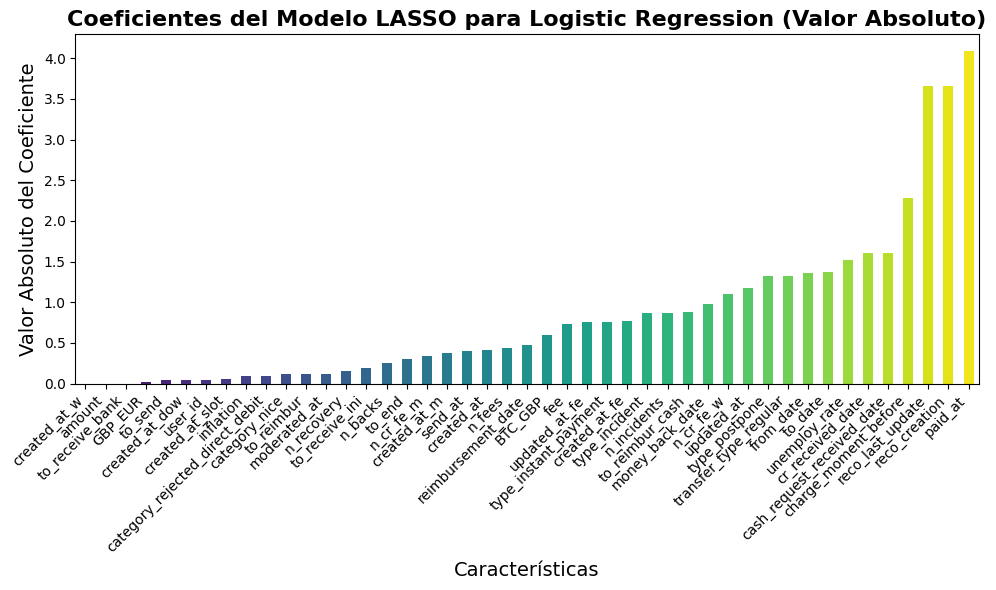

In [14]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series = coefs_series.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

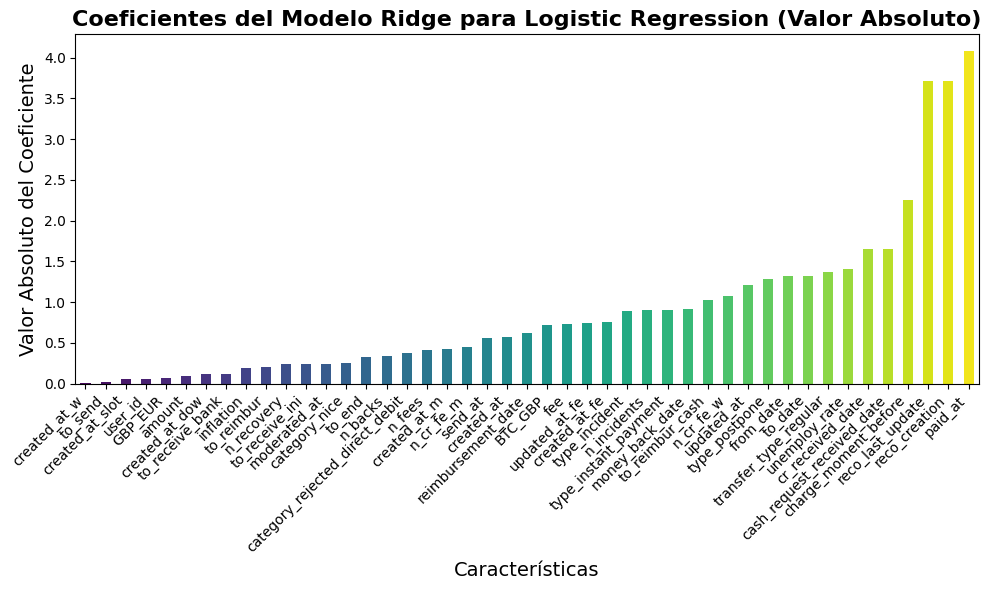

In [15]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series2 = coefs_series2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

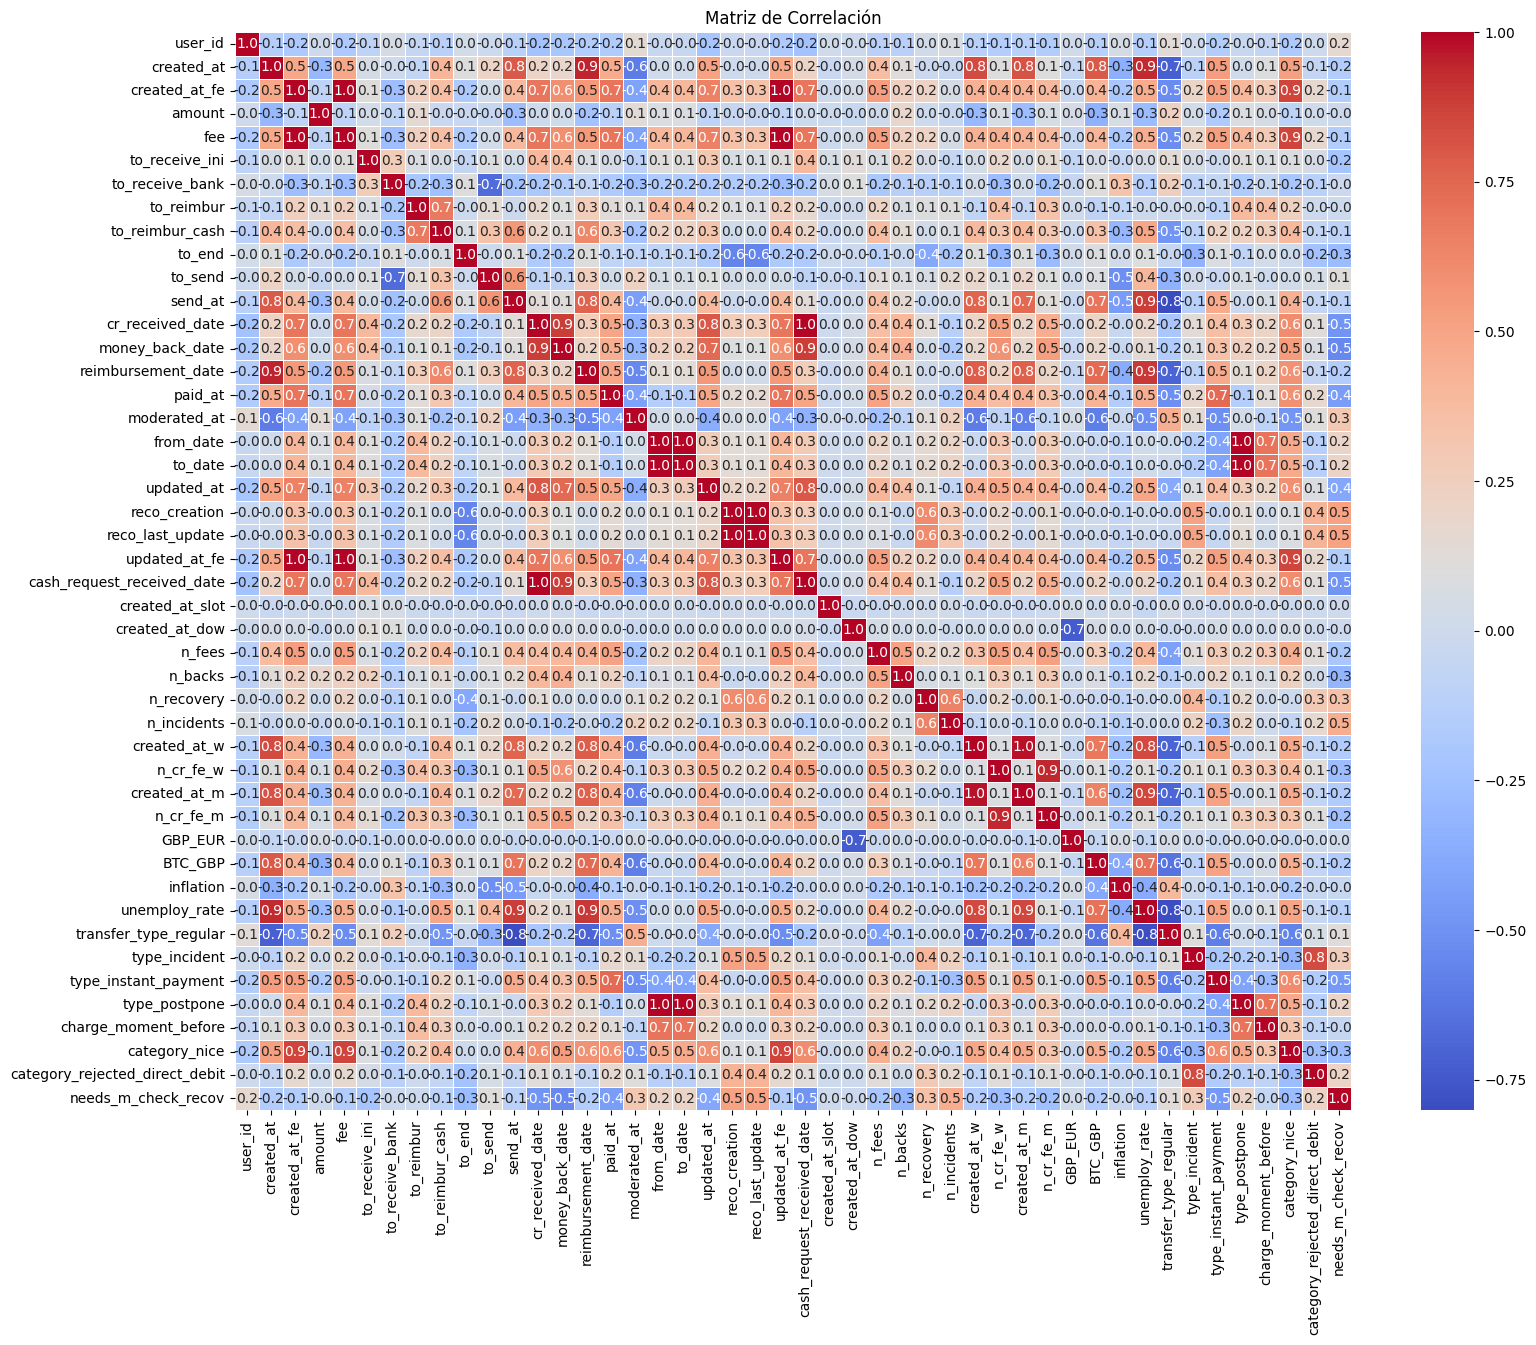

In [11]:
data_matriz= X_log_L
data_matriz['needs_m_check_recov']=y_log_L

# Calcular la matriz de correlación
matriz_correlacion = data_matriz.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(18, 14))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

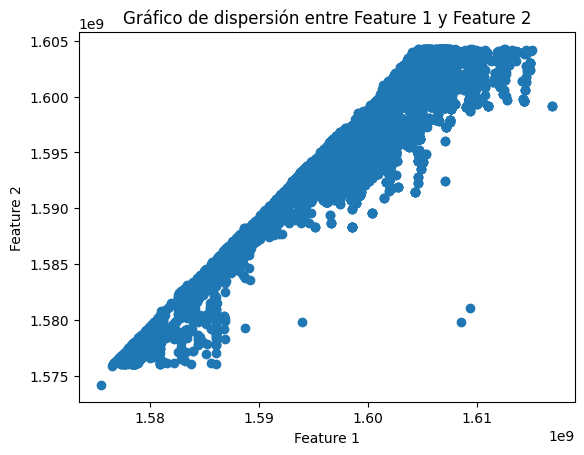

In [18]:
plt.scatter(data_matriz['reimbursement_date'], data_matriz['created_at'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
plt.show()

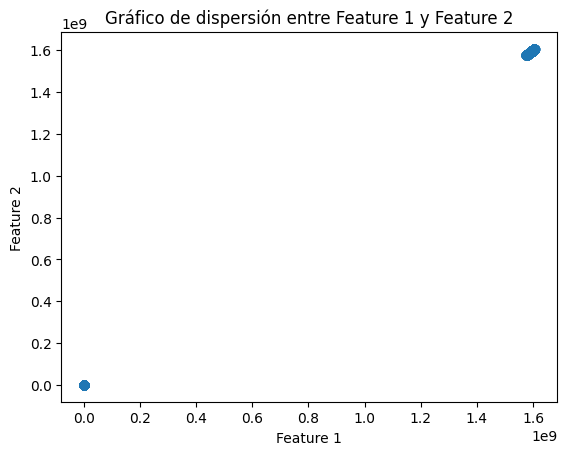

In [19]:
plt.scatter(data_matriz['cash_request_received_date'], data_matriz['cr_received_date'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
plt.show()

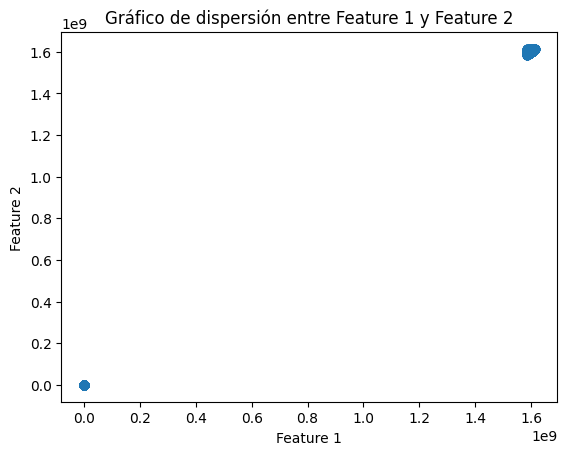

In [20]:
plt.scatter(data_matriz['reco_creation'], data_matriz['reco_last_update'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
plt.show()

In [12]:
# Sacar columnas altamente correlacionadas ['created_at_fe','reimbursememt_date','updated_at_fe','cash_request_received_date','from_date','to_date','category_nice','reco_last_update']
data_matriz=data_matriz.drop(columns=['created_at_fe','reimbursement_date','updated_at_fe','cash_request_received_date','from_date','to_date','category_nice','reco_last_update','cr_received_date'])

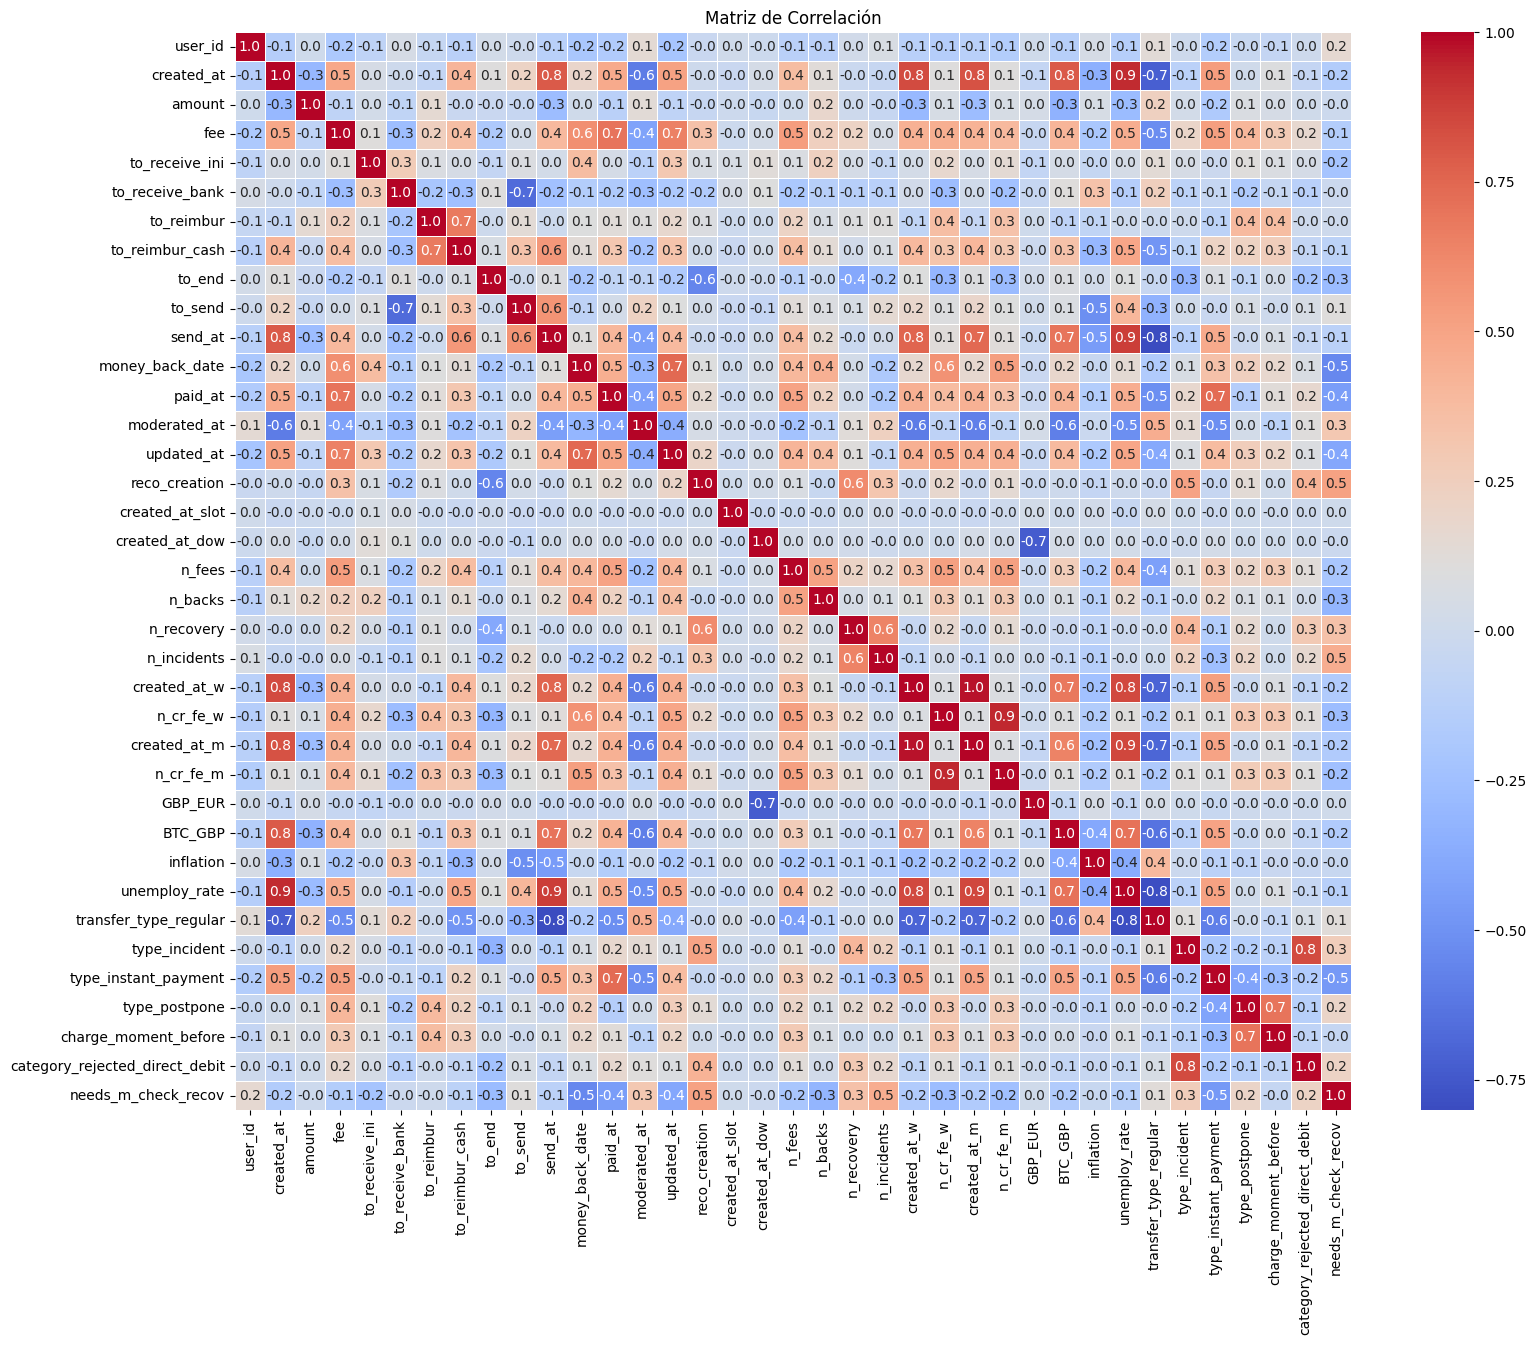

In [14]:
# Calcular la matriz de correlación
matriz_correlacion2 = data_matriz.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(18, 14))
sns.heatmap(matriz_correlacion2, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [15]:
data_matriz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         32092 non-null  int64  
 1   created_at                      32092 non-null  float64
 2   amount                          32092 non-null  float64
 3   fee                             32092 non-null  float64
 4   to_receive_ini                  32092 non-null  float64
 5   to_receive_bank                 32092 non-null  float64
 6   to_reimbur                      32092 non-null  float64
 7   to_reimbur_cash                 32092 non-null  float64
 8   to_end                          32092 non-null  float64
 9   to_send                         32092 non-null  float64
 10  send_at                         32092 non-null  float64
 11  money_back_date                 32092 non-null  float64
 12  paid_at                         

In [16]:
data_matriz.columns = data_matriz.columns.str.strip()
print(data_matriz.columns)


Index(['user_id', 'created_at', 'amount', 'fee', 'to_receive_ini',
       'to_receive_bank', 'to_reimbur', 'to_reimbur_cash', 'to_end', 'to_send',
       'send_at', 'money_back_date', 'paid_at', 'moderated_at', 'updated_at',
       'reco_creation', 'created_at_slot', 'created_at_dow', 'n_fees',
       'n_backs', 'n_recovery', 'n_incidents', 'created_at_w', 'n_cr_fe_w',
       'created_at_m', 'n_cr_fe_m', 'GBP_EUR', 'BTC_GBP', 'inflation',
       'unemploy_rate', 'transfer_type_regular', 'type_incident',
       'type_instant_payment', 'type_postpone', 'charge_moment_before',
       'category_rejected_direct_debit', 'needs_m_check_recov'],
      dtype='object')


In [22]:
# Eliminar la columna 'needs_m_check_recov' usando del
del data_matriz['needs_m_check_recov']

In [24]:
X=data_matriz
y=y_log_L

Coeficientes del modelo de regresión logística (ordenados por magnitud):
created_at: 0.00000006
updated_at: -0.00000006
reco_creation: 0.00000001
user_id: 0.00000000
paid_at: -0.00000000
money_back_date: -0.00000000
send_at: 0.00000000
moderated_at: -0.00000000
BTC_GBP: 0.00000000
to_reimbur: 0.00000000
to_reimbur_cash: 0.00000000
fee: 0.00000000
n_incidents: 0.00000000
to_receive_ini: -0.00000000
created_at_w: 0.00000000
to_receive_bank: -0.00000000
type_postpone: 0.00000000
to_send: -0.00000000
n_fees: 0.00000000
transfer_type_regular: -0.00000000
created_at_m: 0.00000000
n_backs: -0.00000000
to_end: 0.00000000
charge_moment_before: 0.00000000
n_cr_fe_m: -0.00000000
amount: 0.00000000
created_at_dow: -0.00000000
n_cr_fe_w: -0.00000000
created_at_slot: -0.00000000
unemploy_rate: 0.00000000
inflation: -0.00000000
n_recovery: 0.00000000
GBP_EUR: 0.00000000
type_instant_payment: -0.00000000
type_incident: 0.00000000
category_rejected_direct_debit: 0.00000000


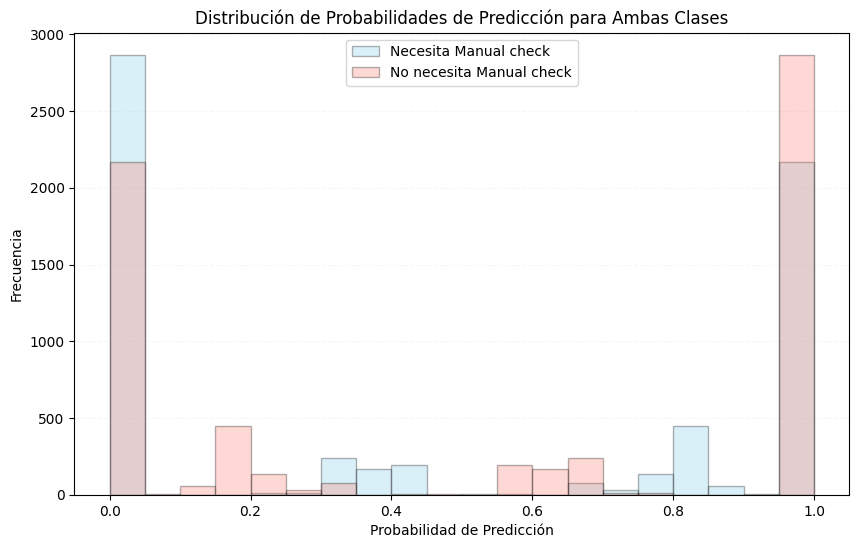

Accuracy: 0.9367502726281353
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3003
           1       0.93      0.95      0.94      3416

    accuracy                           0.94      6419
   macro avg       0.94      0.94      0.94      6419
weighted avg       0.94      0.94      0.94      6419



Text(70.5815972222222, 0.5, 'Realidad')

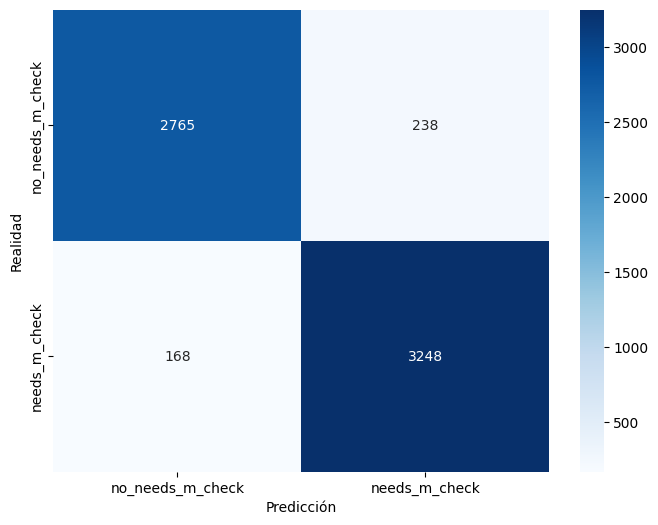

In [25]:
# Probamos MODELO REGRESION LOGISTICA con todas las columnas

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [23]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Lineal CON LA SELECCIÓN para evitar correlaciones altas 

X=data_matriz.drop(columns=['needs_m_check_recov'])
y= data_matriz['needs_m_check_recov']

# X son las características y y es la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42) #probar tb con solver='liblinear'
logreg_l1.fit(X_train_scaled, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42)
logreg_l2.fit(X_train_scaled, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test_scaled)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Exactitud L1 (LASSO): 0.9967284623773174
Exactitud L2 (Ridge): 0.9968842498831594


In [24]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("Características importantes para LASSO:")
print(importancia_no_nula)

Características importantes para LASSO:
                    Característica  Coeficiente
15                   reco_creation     7.290409
12                         paid_at    -4.059208
33                   type_postpone     3.731542
11                 money_back_date    -2.808187
34            charge_moment_before    -2.314665
3                              fee     2.163913
29                   unemploy_rate     1.796573
14                      updated_at    -1.559551
30           transfer_type_regular    -1.450248
32            type_instant_payment    -1.338987
23                       n_cr_fe_w    -1.051804
7                  to_reimbur_cash    -0.900067
21                     n_incidents     0.871431
27                         BTC_GBP    -0.840885
4                   to_receive_ini    -0.703948
31                   type_incident     0.653906
5                  to_receive_bank     0.606790
9                          to_send     0.549087
24                    created_at_m     0.511660


In [25]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
15                   reco_creation     7.151158
12                         paid_at    -3.954140
33                   type_postpone     3.621717
11                 money_back_date    -2.761061
34            charge_moment_before    -2.294917
3                              fee     2.146289
29                   unemploy_rate     1.611833
14                      updated_at    -1.555137
30           transfer_type_regular    -1.521017
32            type_instant_payment    -1.420092
23                       n_cr_fe_w    -1.040211
7                  to_reimbur_cash    -0.964767
27                         BTC_GBP    -0.958008
21                     n_incidents     0.864472
4                   to_receive_ini    -0.731343
5                  to_receive_bank     0.697551
31                   type_incident     0.657480
1                       created_at     0.577041
9                          to_send     0.565653


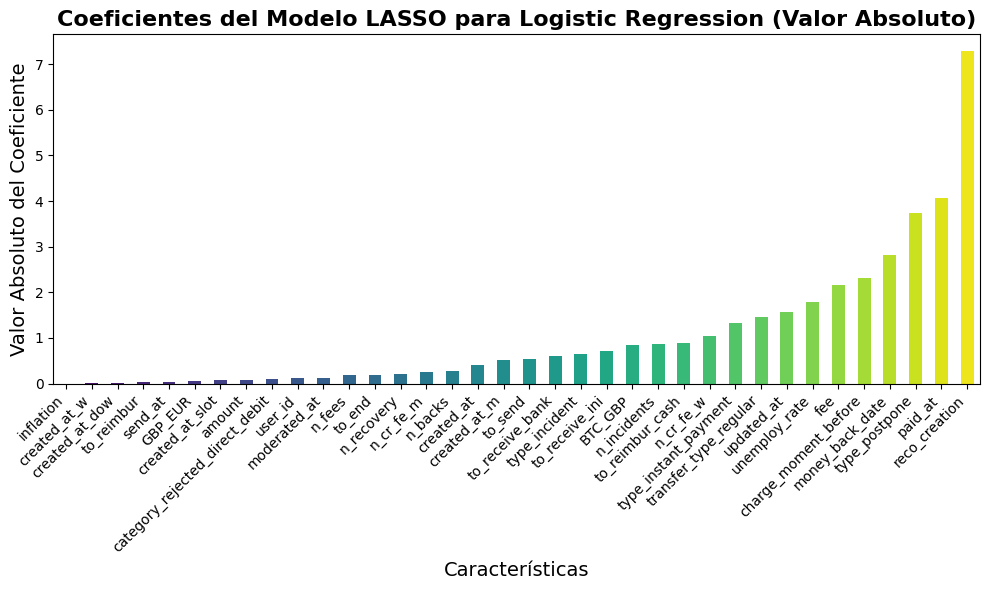

In [26]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series = coefs_series.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

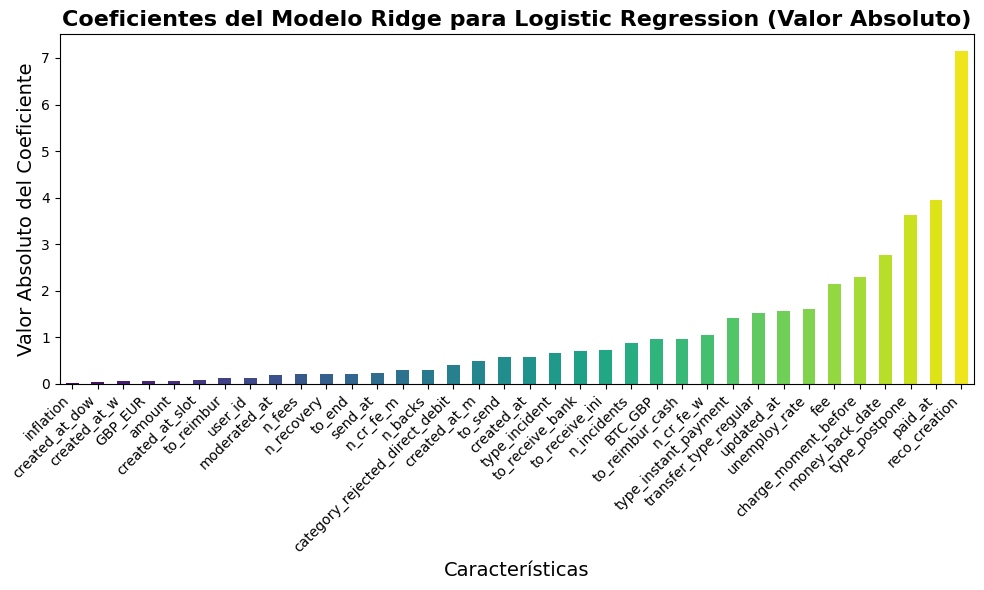

In [27]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series2 = coefs_series2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

Coeficientes del modelo de regresión logística (ordenados por magnitud):
reco_creation: 0.00000001
paid_at: -0.00000000
money_back_date: -0.00000000
unemploy_rate: 0.00000000
fee: 0.00000000
type_postpone: 0.00000000
charge_moment_before: 0.00000000


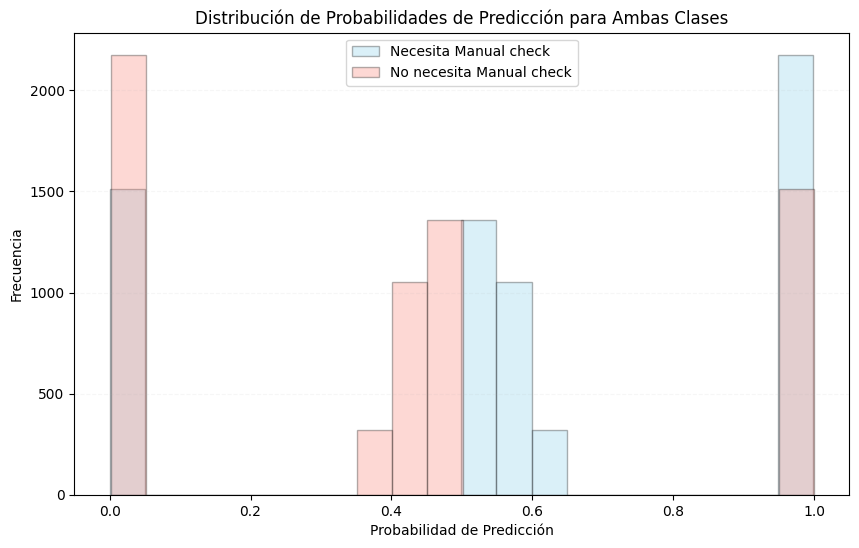

Accuracy: 0.9127589967284624
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      3003
           1       1.00      0.84      0.91      3416

    accuracy                           0.91      6419
   macro avg       0.92      0.92      0.91      6419
weighted avg       0.93      0.91      0.91      6419



Text(70.5815972222222, 0.5, 'Realidad')

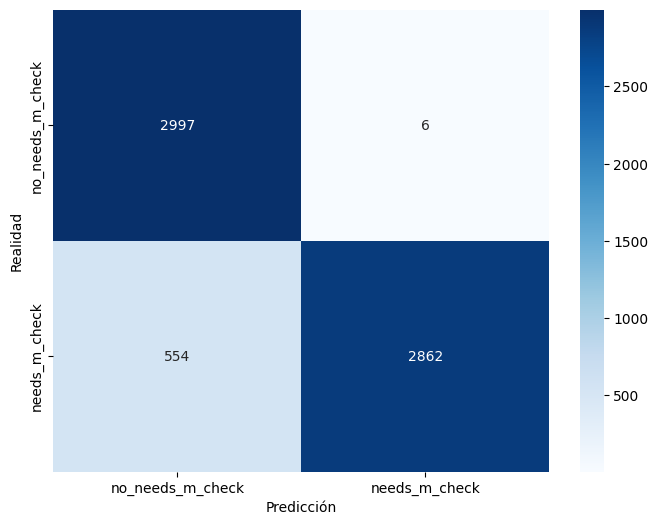

In [28]:
# Probamos MODELO REGRESION LOGISTICA con las columnas más significativas (7 primeras por ejemplo)

X= data_matriz[['reco_creation','paid_at','type_postpone','money_back_date','fee','charge_moment_before','unemploy_rate']]
y=data_matriz['needs_m_check_recov']

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")